In [1]:
import numpy as np
import perceval as pcvl

## Avant de commencer
Voici quelques utilitaires : 

In [2]:
from perceval import pdisplay, PS, BS, Circuit, BasicState, Processor, StateVector
from perceval.backends import BackendFactory
from perceval.algorithm import Analyzer
from exqalibur import FockState
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from numpy import pi, cos, sin
from typing import Optional, List, Tuple


# On reprend notre encodage par rail
qubits = {
    "0": BasicState([1, 0]),
    "1": BasicState([0, 1])
}
qubits_ = {qubits[k]: k for k in qubits}
sqlist = [qubits["0"], qubits["1"]]

# Analyse du circuit
def analyze(circuit: Circuit, input_states: Optional[FockState] = None, output_states: Optional[FockState] = None) \
        -> None:
    if input_states is None:
        input_states = sqlist
    if output_states is None:
        output_states = sqlist
    p = Processor("Naive", circuit)
    a = Analyzer(p, input_states, output_states, mapping=qubits_)
    pdisplay(a)

# Analyse du circuit en calculant les amplitudes
def amplitudes(circuit: Circuit, input_state: Optional[FockState] = None, output_states: Optional[FockState] = None) \
        -> (complex, complex):
    if input_state is None:
        input_state = qubits["0"]
    if output_states is None:
        output_states = sqlist
    b = BackendFactory.get_backend("Naive")
    b.set_circuit(circuit)
    b.set_input_state(input_state)
    return {qubits_[k]: roundc(b.prob_amplitude(k)) for k in output_states}

# Affichage de la sphère de Bloch
def plot_bloch(circuit: Circuit) -> None:
    ampl = amplitudes(circuit)
    return plot_bloch_multivector(Statevector([ampl["0"], ampl["1"]]))

# Rotations
x_rot = lambda x: Circuit(2) // (0, PS(pi)) // BS.Rx(theta=x) // (0, PS(pi)) 
y_rot = lambda x: BS.Ry(theta=x)
z_rot = lambda x: BS.H() // x_rot(x) // BS.H() 

# Trigonométrie avec Matplotlib 
def plot_trig(angles, colors=None, annotations=None):
    r = 1.5
    if colors is None:
        colors = ["blue"] * len(angles)
    if annotations is None:
        annotations = [""] * len(angles)
    for angle, color, annotation in zip(angles, colors, annotations):
        pos_x = r * cos(angle)
        pos_y = r * sin(angle)
        plt.plot([0, pos_x], [0, pos_y], color=color)
        pos_x_a = pos_x + np.sign(pos_x) * 0.1 - (0.05 * len(annotation) if np.sign(pos_x) < 0 else 0)
        pos_y_a = pos_y + np.sign(pos_y) * 0.1
        plt.gca().annotate(annotation, xy=(pos_x_a, pos_y_a), xycoords='data', fontsize=10)

    plt.plot(0, 0, color='black', marker='o')
    a = np.linspace(0 * pi, 2 * pi, 100)
    xs, ys = r * cos(a), r * sin(a)
    plt.plot(xs, ys, color="black")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal')
    plt.show()

# Version de `round()` pour les nombres complexes.
def roundc(c: complex, decimals: int = 2) -> complex:
    return round(c.real, decimals) + round(c.imag, decimals) * 1j

### Exemples

{'0': (0.71+0j), '1': (0.71+0j)}


,0,1
0,1/2,1/2
1,1/2,1/2


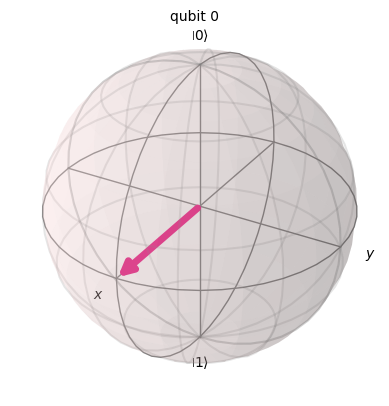

In [3]:
hadamard_gate = BS.H()
print(amplitudes(hadamard_gate))
analyze(hadamard_gate)
plot_bloch(hadamard_gate)

Il n'existe pas uniquement la sphère de Bloch pour représenter des qubits, on peut simplement utiliser un cercle trigonométrique. La transition est explicite : **l'abscisse correspond à $|0\rangle$ et l'ordonnée à $|1\rangle$**, $|+\rangle$ se retrouve donc à $\frac{\pi}{4}$. Tous les états sont sur le cercle, car la somme des probabilités, qui ici est une amplitude, est toujours $1$. On perd néanmoins, avec cet affichage, l'information de la phase globale.

Par exemple, voici la base canonique (en bleu) et la base d'Hadamard (en rouge) : 

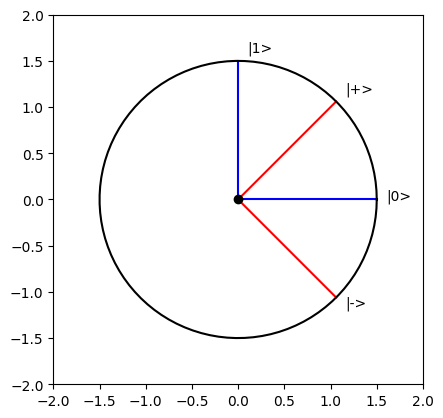

In [4]:
plot_trig([0, pi/2, pi/4, -pi/4], ["blue", "blue", "red", "red"], ["|0>", "|1>", "|+>", "|->"])

Pour ce challenge, comme nous n'avons pas besoin de phase, mais de visualiser plusieurs bases différentes en même temps, nous allons utiliser uniquement la représentation avec le cercle trigonométrique.

# Challenge 2 : Attaque de la femme du milieu (version quantique)

Vous connaissez tous l'attaque de *Man In The Middle* classique, un attaquant intercepte une communication entre deux entités qui ne se rendent pas compte que leur conversation est écoutée. Je vous propose aujourd'hui de découvrir la **version quantique !** **Alice** et **Bob** (oui, encore eux, même les physiciens sont fan), décident de s'échanger une clef secrète avec le **protocole BB84**. Étant certains de la fiabilité de leur protocole, ils laissent une tolérance au bruit. Cependant, **Eve** réussit à intercepter le canal de discussion. Va-t-elle réussir à passer inaperçu ? 

## Protocol BB84 : Utilisation normale
Le protocol BB84 permet de s'échanger une clef de $n$ bits avec $4n$ qubits. Il se base sur le principe que, si quelqu'un venait à écouter la conversation, cette personne serait obligée de **mesurer** les qubits, et donc d'effondrer les fonctions d'ondes associées (une mesure est une projection et donc une perte d'information). **Cet effondrement est ainsi visible**, apportant une erreur de $25\%$ lors de l'étape de vérification. 

### Étape 1 : Alice prépare ses qubits à envoyer
**1.a)** Il faut tout d'abord une clef, pour cela, une chaîne binaire aléatoire de taille $4n$ est générée. 

*Il est possible de générer cette chaîne avec un ordinateur quantique pour de l'aléatoire de meilleure qualité.*

In [5]:
N = 100
bits_alice = np.random.randint(low=0, high=2, size=(4 * N,))

**1.b)** Alice va ensuite choisir $4n$ bases aléatoires dans $\{+, \times\}$, dans lesquelles elle va encoder ses qubits. *(Veuillez m'excuser pour la confusion entre la base $+$ et l'état $|+\rangle$ qui n'ont rien à voir, je prends les mêmes conventions que la littérature)*.

La base $+$ est la base canonique : 
$$
+ = \left\{ \begin{pmatrix} 1 \\ 0 \end{pmatrix}, \begin{pmatrix} 0 \\ 1 \end{pmatrix}\right\}
$$

Tandis que la base $\times$ est définie par : 
$$
\times = \left\{\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}, \frac{1}{\sqrt{2}}\begin{pmatrix} -1 \\ 1 \end{pmatrix}\right\}
$$

On peut les visualiser : 

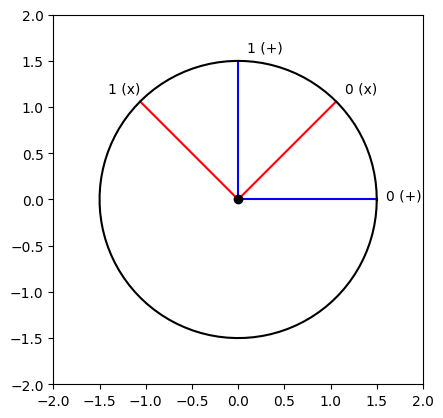

In [6]:
plot_trig([0, pi/2, pi/4, 3*pi/4], ["blue", "blue", "red", "red"], ["0 (+)", "1 (+)", "0 (x)", "1 (x)"])

L'encodage est entièrement représenté sur ce schéma : $1$ dans la base $\times$ sera codé :
$$
-\frac{\sqrt{2}}{2} \begin{pmatrix} 1 \\ 0 \end{pmatrix} + \frac{\sqrt{2}}{2} \begin{pmatrix} 0 \\ 1 \end{pmatrix} =  -\frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle
$$

*Pour rappel, avec l'encodage par rail que l'on a vu précédemment, cela donne :* 
$$
-\frac{1}{\sqrt{2}} |1, 0\rangle + \frac{1}{\sqrt{2}} |0, 1\rangle
$$
*Peu importe le nom que l'on donne à nos vecteurs de notre base, ici canonique, cela ne change évidemment rien aux calculs. Je ne l'ai pas précisé, mais (presque) tout ce qui est fait dans le cadre de cette compétition est reproduisable sur des ordinateurs quantiques possédants des technologies différentes. Il suffit d'adapter l'encodage du qubit, les calculs sont les mêmes.*

In [7]:
bases_alice = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4 * N,))])

**1.c)** Alice peut maintenant encoder ses $4n$ qubits dans ses $4n$ bases. *J'utilise des `StateVector`, qui est une généralisation des `BasicState` qu'on a rencontré. Cela me permet d'effectuer des opérations sur les états plus facilement, sans me soucier de la normalisation qui est effectuée automatiquement.* 

***>> Attention aux `StateVector` qui peuvent être méchants, `3 * a + b` marche, alors que `a + 3 * b` non !***
*Attention aussi à la confusion entre le `Statevector` de Qiskit et le `StateVector` de Perceval, on utilise les deux ...*

In [8]:
qubits_alice = []

# Pour pouvoir tester plus facilement, je définis les valeurs de 0 et de 1 dans la base X, attention, ce 
# ne sont plus des BasicState, mais des StateVector, il faut donc utiliser la fonction measure (voir
# ci-dessous) pour les manipuler
qubits["0x"] = qubits["0"] + qubits["1"] 
qubits["1x"] = qubits["1"] - qubits["0"] 
print(type(qubits["0"]), type(qubits["0x"]))

for bit, basis  in zip(bits_alice, bases_alice):
    if basis == "+":
        s = pcvl.StateVector(qubits["0"]) if bit == 0 else pcvl.StateVector(qubits["1"])
    else: 
        s = qubits["0x"] if bit == 0 else qubits["1x"]
    qubits_alice.append(s)

    # On affiche les 9 premiers pour vérifier :
    if len(qubits_alice) < 10: 
        print(f"Bit à encoder : {bit}, base choisie : {basis}, qubit correspondant : {s}")

<class 'exqalibur.FockState'> <class 'exqalibur.StateVector'>
Bit à encoder : 0, base choisie : +, qubit correspondant : |1,0>
Bit à encoder : 0, base choisie : +, qubit correspondant : |1,0>
Bit à encoder : 1, base choisie : +, qubit correspondant : |0,1>
Bit à encoder : 1, base choisie : x, qubit correspondant : -sqrt(2)/2*|1,0>+sqrt(2)/2*|0,1>
Bit à encoder : 0, base choisie : x, qubit correspondant : sqrt(2)/2*|0,1>+sqrt(2)/2*|1,0>
Bit à encoder : 1, base choisie : +, qubit correspondant : |0,1>
Bit à encoder : 1, base choisie : +, qubit correspondant : |0,1>
Bit à encoder : 1, base choisie : x, qubit correspondant : -sqrt(2)/2*|1,0>+sqrt(2)/2*|0,1>
Bit à encoder : 0, base choisie : +, qubit correspondant : |1,0>


Maintenant qu'Alice a préparé ses qubits, elle peut les envoyer à Bob. *Par exemple à l'aide d'un photon.*

### Étape 2 : récupération par Bob et décodage

Bob **ne connait pas les bases dans lesquelles ont été encodés les qubits**, il va donc choisir aléatoirement $4n$ bases comme Alice, et va mesurer les qubits d'Alice. Seuls la moitié des bits seront ainsi juste, étant donné qu'il a une chance sur deux à chaque fois de tomber sur la même base qu'Alice.

Une fois qu'il a mesuré les qubits, ceux-ci se sont effondrés, personne ne peut plus les avoir. C'est une notion importante à comprendre. Dans le monde classique, l'on peut envoyer un message tout en gardant une version de son contenu de notre côté, ce n'est pas comme si à chaque message que l'on envoyait, il s'effaçait de notre téléphone, et de notre mémoire. Dans le monde quantique cependant, c'est le cas ! Il y a même un théorème dédié : le **théorème de non-clonage.** Il ne peut exister deux instances de la même information quantique, donc quand on mesure un qubit, on est sûr que l'information n'existe plus **nulle part.** C'est évidemment très pratique dans le monde de la cyber. On peut effectuer des actions après mesure avec des garanties. La RGPD quantique déjà au taquet !

**2.a)** Bob choisit aléatoirement $4n$ bases : 

In [9]:
bases_bob = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4*N,))])

Pour simuler une mesure, on va utiliser le processeur "SLOS" : 

In [10]:
def measure(input_state, circuit, full=False):
    p = pcvl.Processor("SLOS", circuit)
    p.with_input(input_state)
    sampler = pcvl.algorithm.Sampler(p)

    # Mesure (complète) faite avec 1000 essais, on se retrouve donc avec un résultat semblable 
    # à l'Analyser
    if full:
        sample_count = sampler.sample_count(1000)
        return sample_count['results']
        
    sample_count = sampler.sample_count(1)
    return list(sample_count['results'].keys())[0]

**2.b)** Bob prépare les circuits nécessaires à ces mesures.

Pour mesurer dans la base $+$, il suffit de prendre l'identité vu que c'est notre base canonique : 

In [11]:
base_p = Circuit(2)

On peut vérifier :

In [12]:
print(f"""
0 dans la base + : {measure(qubits["0"], base_p, full=True)}
1 dans la base + : {measure(qubits["1"], base_p, full=True)}
0 dans la base x ({qubits["0x"]}) mesurée dans la base + : {measure(qubits["0x"], base_p, full=True)}
1 dans la base x ({qubits["1x"]}) mesurée dans la base + : {measure(qubits["1x"], base_p, full=True)}
""")


0 dans la base + : {
  |1,0>: 1000
}
1 dans la base + : {
  |0,1>: 1000
}
0 dans la base x (sqrt(2)/2*|0,1>+sqrt(2)/2*|1,0>) mesurée dans la base + : {
  |1,0>: 486
  |0,1>: 514
}
1 dans la base x (-sqrt(2)/2*|1,0>+sqrt(2)/2*|0,1>) mesurée dans la base + : {
  |0,1>: 505
  |1,0>: 495
}


Comme prévu, aucun moyen de déterminer le bit d'Alice si Bob se trompe de base. On fait de même pour la base $\times$. Cette fois, on utilise une rotation de $-\frac{\pi}{4}$ (passage de la base $\times$ à notre base canonique). J'utilise pour cela une rotation $y$ avec un angle de $-\frac{\pi}{2}$, cela est dû aux différences de conventions entre la sphère de Bloch et notre cercle trigonométrique. 

In [13]:
base_x = y_rot(-pi/2)

print(f"""
0 dans la base x : {measure(qubits["0x"], base_x, full=True)}
1 dans la base x : {measure(qubits["1x"], base_x, full=True)}
0 dans la base + ({qubits["0"]}) mesurée dans la base x : {measure(qubits["0"], base_x, full=True)}
1 dans la base + ({qubits["1"]}) mesurée dans la base x : {measure(qubits["1"], base_x, full=True)}
""")


0 dans la base x : {
  |1,0>: 1000
}
1 dans la base x : {
  |0,1>: 1000
}
0 dans la base + (|1,0>) mesurée dans la base x : {
  |1,0>: 489
  |0,1>: 511
}
1 dans la base + (|0,1>) mesurée dans la base x : {
  |1,0>: 501
  |0,1>: 499
}


**2.c)** Bob mesure les qubits envoyés par Alice dans ses bases. 

In [14]:
bits_bob = []
for q, b in zip(qubits_alice, bases_bob): 
    if b == "+":
        bits_bob.append(0 if measure(q, base_p) == qubits["0"] else 1)
    else:
        bits_bob.append(0 if measure(q, base_x) == qubits["0"] else 1)
bits_bob = np.array(bits_bob)

On peut calculer la correspondance avec la clef d'Alice : 

In [15]:
correspondance_secret_key_bits_bob = bits_bob == bits_alice
np.sum(correspondance_secret_key_bits_bob) / (4 * N)

0.76

On a bien $\sim 75\%$ d'équivalence : dans $50\%$ des cas, Alice et Bob ont la même base donc les mêmes valeurs. Il y a $25\%$ en plus, car quand ils n'ont pas la même base, il y a $50\%$ de réussite. 

### Étape 3 : Alice et Bob se mettent d'accord.

Une fois que les qubits ont été mesurés par Bob, Bob va **rendre ses bases publiques**, et Alice va pouvoir lui dire où il y a correspondance, et donc où ils peuvent être sûr d'avoir la même chose.

In [16]:
correspondance_bases_alice_bob = bases_bob == bases_alice 
half_bits_bob = bits_bob[correspondance_bases_alice_bob]
half_bits_alice = bits_alice[correspondance_bases_alice_bob]
# ATTENTION : Ne pas relancer la cellule toute seule, relancer tout le notebook pour rafraichir cette cellule correctement. 

### Étape 4 : Vérification de l'intégrité de la communication.

Pour vérifier qu'il n'y a pas eu d'écoute, Alice et Bob vont **rendre publique la moitié de leur clef commune.** Si il y a correspondance totale, alors on est sûr que personne n'a écouté. 

In [17]:
last_slice = len(half_bits_bob) // 2
verification = half_bits_bob[:last_slice] == half_bits_alice[:last_slice]
print(f"Pourcentage de correspondance : {int(np.sum(verification) / last_slice * 100)}%")

Pourcentage de correspondance : 100%


D'où *in fine*, la clef secrète avec une taille environ égale à $n$ (On peut trouver un $n'$ tel que la probabilité d'avoir $|clef| > n$ soit arbitrairement grande, puis couper à $n$) : 

In [18]:
secret_key = half_bits_bob[last_slice:]
print(f"Secret key : {secret_key}, taille : {len(secret_key)}")

Secret key : [0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1
 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1
 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1], taille : 97


## Protocol BB84 : Ève entre en scène 

Tout est identique, sauf que maintenant, Ève intercepte la communication et va essayer de déduire une partie de la clef échangée. 

### Étape 1 : Réimplémentez le protocole, en rajoutant Ève au milieu *(pas nécessaire pour obtenir le drapeau, mais recommandé pour faciliter la suite)*

Ève utilise dans un premier temps la même stratégie que Bob et Alice, elle se fait d'abord passer pour Bob, puis pour Alice, en effectuant les mêmes actions d'encodage/ décodage. 

In [19]:
N = 100

# Alice prépare ses qubits
bits_alice = np.random.randint(low=0, high=2, size=(4 * N,))
bases_alice = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4 * N,))])
qubits_alice = []
for bit, basis  in zip(bits_alice, bases_alice):
    if basis == "+":
        s = pcvl.StateVector(qubits["0"]) if bit == 0 else pcvl.StateVector(qubits["1"])
    else:
        s = qubits["0x"] if bit == 0 else qubits["1x"]
    qubits_alice.append(s)


# Ève les intercepte et applique la même méthode que Bob en se faisant passer pour lui
bases_eve = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4 * N,))])
bits_eve = []
for q, b in zip(qubits_alice, bases_eve):
    if b == "+":
        bits_eve.append(0 if measure(q, base_p) == qubits["0"] else 1)
    else:
        bits_eve.append(0 if measure(q, base_x) == qubits["0"] else 1)
bits_eve = np.array(bits_eve)


# Elle renvoie ensuite les qubits correspondants pour se faire passer pour Alice
qubits_eve = []
for bit, basis  in zip(bits_eve, bases_eve):
    if basis == "+":
        s = pcvl.StateVector(qubits["0"]) if bit == 0 else pcvl.StateVector(qubits["1"])
    else:
        s = qubits["0x"] if bit == 0 else qubits["1x"]
    qubits_eve.append(s)
    

# Bob reçoit les qubits d'Ève et applique la même méthode que précédemment 
bases_bob = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4 * N,))])
bits_bob = []
for q, b in zip(qubits_eve, bases_bob):
    if b == "+":
        bits_bob.append(0 if measure(q, base_p) == qubits["0"] else 1)
    else:
        bits_bob.append(0 if measure(q, base_x) == qubits["0"] else 1)
bits_bob = np.array(bits_bob)


# Dernière étape : mise en commun
correspondance_bases_alice_bob = bases_bob == bases_alice
half_bits_alice = bits_alice[correspondance_bases_alice_bob]
half_bits_bob = bits_bob[correspondance_bases_alice_bob]
last_slice = len(half_bits_alice) // 2


# Vérification du bon déroulé 
verification = half_bits_alice[:last_slice] == half_bits_bob[:last_slice]
correspondance_percentage = int(np.sum(verification) / last_slice * 100)

print(f"Pourcentage de correspondance : {correspondance_percentage}%, d'où une erreur de {100 - correspondance_percentage}%.")

secret_key_step_1 = half_bits_bob[:last_slice]

Pourcentage de correspondance : 68%, d'où une erreur de 32%.


En faisant les calculs, on montre que l'erreur est en moyenne de $25\%$· En échangeant un grand nombre de bits, on se rapproche de cette moyenne et l'on peut donc détecter une écoute. 

In [20]:
print(secret_key_step_1)

[0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1
 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1]


Ce n'est pas exactement la clef, il faudra encore utiliser des codes correction d'erreurs pour qu'Alice et Bob se retrouvent avec la même clef. Dans le cadre de ce challenge, on va s'arrêter ici.

Dans ce cas-là, Ève se fait détecter. Mais il est possible de réduire l'erreur, certes de peu, mais cela peut permettre de passer pour du bruit. On va supposer pour simplifier que : **une erreur en dessous de $20\%$ est considérée comme du bruit.**

### Étape 2 : Ève contre-attaque, trouvez un moyen de faire descendre l'erreur moyenne à $20\%$ (ou en dessous).

*Le protocole reste le même, les seuls paramètres modifiables sont les bases de mesure pour mesurer les qubits d'Alice et les qubits à envoyer à Bob.*

<h1 style="color:green">Solution : </h1>

Pour augmenter la précision lors de la capture des qubits et du renvoi des qubits, Eve peut utiliser la base de Breidbart. Les explications détaillées sont fournies par exemple dans le papier <a href="A_new_attack_strategy_for_BB84_protocol_based_on_Breidbart_basis.pdf">A new attack strategy for BB84 protocol based on Breidbart basis</a>.

L'intuition derrière ce choix de base est que l'on va effectivement se tromper à chaque fois, mais que l'on va "moins" se tromper.

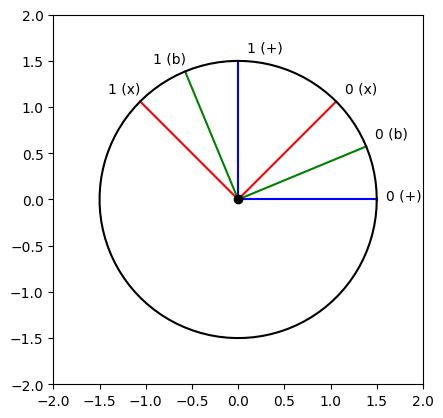

In [21]:
plot_trig([0, pi/2, pi/4, 3*pi/4, pi/8, 5*pi/8], ["blue", "blue", "red", "red", "green", "green"], ["0 (+)", "1 (+)", "0 (x)", "1 (x)", "0 (b)", "1 (b)"])

In [22]:
# Les qubits de la base de Breidbart peuvent être définis par : 
qubits["0b"] = pcvl.StateVector(qubits["0"]) + qubits["0x"]
qubits["1b"] = pcvl.StateVector(qubits["1"]) + qubits["1x"]

# Et la base en elle-même par : 
base_b = y_rot(-pi/4)

# On peut vérifier avec : 
print(f"""
0 dans la base b : {measure(qubits["0b"], base_b, full=True)}
1 dans la base b : {measure(qubits["1b"], base_b, full=True)}
0 dans la base + ({qubits["0"]}) mesurée dans la base b : {measure(qubits["0"], base_b, full=True)}
1 dans la base + ({qubits["1"]}) mesurée dans la base b : {measure(qubits["1"], base_b, full=True)}
0 dans la base x ({qubits["0x"]}) mesurée dans la base b : {measure(qubits["0x"], base_b, full=True)}
1 dans la base x ({qubits["1x"]}) mesurée dans la base b : {measure(qubits["1x"], base_b, full=True)}
""")


0 dans la base b : {
  |1,0>: 1000
}
1 dans la base b : {
  |0,1>: 1000
}
0 dans la base + (|1,0>) mesurée dans la base b : {
  |1,0>: 865
  |0,1>: 135
}
1 dans la base + (|0,1>) mesurée dans la base b : {
  |1,0>: 169
  |0,1>: 831
}
0 dans la base x (sqrt(2)/2*|0,1>+sqrt(2)/2*|1,0>) mesurée dans la base b : {
  |1,0>: 838
  |0,1>: 162
}
1 dans la base x (-sqrt(2)/2*|1,0>+sqrt(2)/2*|0,1>) mesurée dans la base b : {
  |1,0>: 150
  |0,1>: 850
}


In [23]:
N = 1000

# Alice prépare ses qubits
bits_alice = np.random.randint(low=0, high=2, size=(4 * N,))
bases_alice = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4 * N,))])
qubits_alice = []
for bit, basis  in zip(bits_alice, bases_alice):
    if basis == "+":
        s = pcvl.StateVector(qubits["0"]) if bit == 0 else pcvl.StateVector(qubits["1"])
    else:
        s = qubits["0x"] if bit == 0 else qubits["1x"]
    qubits_alice.append(s)


# Interception
bits_eve = np.array([0 if measure(q, base_b) == qubits["0"] else 1 for q in qubits_alice])

# Envoi
qubits_eve = []
for b in bits_eve:
    if b == 0:
        qubits_eve.append(qubits["0b"])
    else:
        qubits_eve.append(qubits["1b"])
    

# Bob reçoit les qubits d'Ève et applique la même méthode que précédemment 
bases_bob = np.array(["+" if b == 0 else "x" for b in np.random.randint(low=0, high=2, size=(4 * N,))])
bits_bob = []
for q, b in zip(qubits_eve, bases_bob):
    if b == "+":
        bits_bob.append(0 if measure(q, base_p) == qubits["0"] else 1)
    else:
        bits_bob.append(0 if measure(q, base_x) == qubits["0"] else 1)
bits_bob = np.array(bits_bob)


# Dernière étape : mise en commun
correspondance_bases_alice_bob = bases_bob == bases_alice
half_bits_alice = bits_alice[correspondance_bases_alice_bob]
half_bits_bob = bits_bob[correspondance_bases_alice_bob]
last_slice = len(half_bits_alice) // 2


# Vérification du bon déroulé 
verification = half_bits_alice[:last_slice] == half_bits_bob[:last_slice]
correspondance_percentage = int(np.sum(verification) / last_slice * 100)

print(f"Pourcentage de correspondance : {correspondance_percentage}%, d'où une erreur de {100 - correspondance_percentage}%.")

secret_key_step_1 = half_bits_bob[:last_slice]

Pourcentage de correspondance : 80%, d'où une erreur de 20%.


## Récupération du drapeau 

Le jour où j'arrive à faire marcher `pcvl.random_seed(66)` je vous demanderai les clefs. En attendant, je veux bien les deux bases utilisées lors de l'étape 2, ainsi que les deux types de qubits envoyés par Ève. 

Vous pouvez venir en DM si vous avez des problèmes. 

In [24]:
import requests as rq
def circuit_to_list(circuit: Circuit) -> List[List[Tuple[float, float]]]:
    return [[(x.real, x.imag) for x in l] for l in np.array(circuit.compute_unitary())]
    
def state_vector_to_list(sv: StateVector) -> List[Tuple[float, float]]:
    if type(sv) is not StateVector:
        sv = pcvl.StateVector(sv)
    sv.normalize()
    r = [(0., 0.), (0., 0.)]
    for k, v in sv:
        r[int(qubits_[k])] = (v.real, v.imag)
    return r

def list_to_state_vector(p: List[Tuple[float, float]]) -> StateVector:
    return complex(p[0][0], p[0][1]) * StateVector([1, 0]) + complex(p[1][0], p[1][1]) * StateVector([0, 1]) 

In [25]:
# Exemple pour la version de l'étape 1 : 
# example_base_eve_1 = base_p 
# example_base_eve_2 = base_x
# example_qubit_eve_1 = qubits["0"]
# example_qubit_eve_2 = qubits["1"]
# example_qubit_eve_3 = qubits["0x"]
# example_qubit_eve_4 = qubits["1x"]

d = {
    "base_eve_1": circuit_to_list(base_b),
    "base_eve_2": circuit_to_list(base_b),
    "qubit_eve_1": state_vector_to_list(qubits["0b"]),
    "qubit_eve_2": state_vector_to_list(qubits["1b"]),
    "qubit_eve_3": state_vector_to_list(qubits["0b"]),
    "qubit_eve_4": state_vector_to_list(qubits["1b"])
}
# raise NotImplementedError

In [26]:
URL = "http://localhost:8000"
rq.get(URL + "/healthcheck").json()

{'message': 'Statut : en pleine forme !'}

In [27]:
rq.post(URL + "/challenges/2", json=d).json()

{'message': 'GG ! Voici le drapeau : 404CTF{m0Y3nN3m3Nt_d1sCR3t_t0ut_d3_M3m3}'}